In [85]:
import numpy as np
import cudaq
from cuquantum import custatevec
import cupy as cp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gc
from cudaq import Schedule
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import pacf
from scipy.sparse import dok_matrix
import pywt

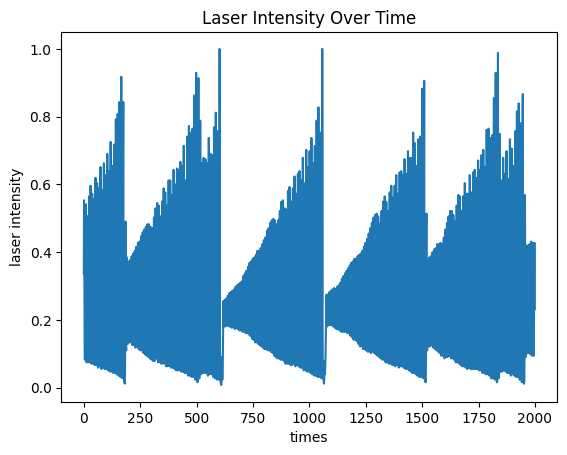

In [86]:
laser_data = pd.read_csv("data/Laser.csv")
laser_data_normalized = laser_data["laser"] / 255  # Normalize laser intensity

# Plot the first 2000 data points
plt.plot(laser_data_normalized[:2000], label="")
plt.xlabel("times")
plt.ylabel("laser intensity")
plt.title("Laser Intensity Over Time")
plt.show()

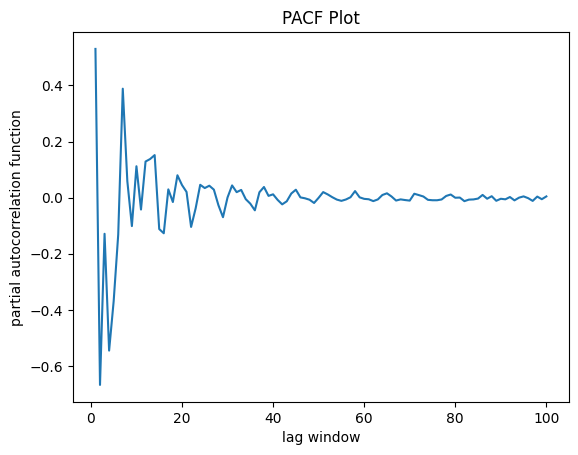

In [87]:
lnw = 100

# Assuming `laser_data` is already normalized and loaded
# Calculate partial autocorrelation function (PACF)
acc = pacf(laser_data_normalized, nlags=lnw, method='ols')  # Use regression method

# Plot the PACF
lags = np.arange(1, lnw + 1)
plt.plot(lags, acc[1:lnw + 1], label="")  # Skip lag 0 for consistency
plt.xlabel("lag window")
plt.ylabel("partial autocorrelation function")
plt.title("PACF Plot")
plt.show()

In [10]:
# Set the sliding window size
window = 10

# Split the data into training and testing sets
train_data = laser_data_normalized[:1400]
test_data = laser_data_normalized[1400:2000]

# Calculate lengths of training and testing data
ln_train = len(train_data)
ln_test = len(test_data)

# Generate training features and outcomes using sliding window
train_features = np.vstack([train_data[i:(i + window)] for i in range(ln_train - window)])
train_outcomes = train_data[window:]

# Generate testing features and outcomes using sliding window
test_features = np.vstack([test_data[i:(i + window)] for i in range(ln_test - window)])
test_outcomes = test_data[window:]

In [11]:
class RydbergSimulator:
    def __init__(self, nsites, atoms, readouts, omega, t_start, t_end, t_step, t_rate, alpha, V_matrix, id):
        """
        Initialize the RydbergSimulator class.
        Parameters:
        - atoms: Atom positions
        - readouts: Readout observables
        - omega: Rabi frequency
        - t_start: Evolution starting time
        - t_end: Evolution ending time
        - t_step: Window time step
        - t_rate: Measurement rate per step
        - alpha: Site modulation factors
        - V_matrix: Interaction strength matrix
        """
        self.nsites = nsites 
        self.atoms = atoms
        self.readouts = readouts
        self.omega = omega
        self.t_start = t_start
        self.t_end = t_end
        self.t_step = t_step
        self.t_rate = t_rate
        self.alpha = alpha
        self.V_matrix = V_matrix
        self.dimensions = {i: 2 for i in range(len(atoms))}
        self.id = id



        # Schedule of time steps
        t_final = t_end
        n_steps = int((t_end - t_start) / t_step) + 1
        self.steps = np.linspace(0, t_final, n_steps)
        self.schedule = Schedule(self.steps, ["t"])

        #cp.cuda.Device(self.id).use()
        # Initial state of the system (all qubits in the ground state)
        cp.cuda.Device(0).use()
        self.rho0 = cp.asarray(np.zeros((2**self.nsites, 2**self.nsites), dtype=cp.complex64)) 
        self.rho0[0,0] = 1.0  # All qubits in the ground state
        self.rho0 = cudaq.State.from_data(self.rho0)

    def rydberg_hamiltonian(self, x):
        """
        Construct the Rydberg Hamiltonian H(t) using wavelet-transformed features.
        Parameters:
        - x: Detuning parameter vector (Delta_g(t) + alpha_j * Delta_l(t))
        """
        num_atoms = len(self.atoms)
        hamiltonian = cudaq.SpinOperator()

        # Perform wavelet transform on x
        wavelet = 'db1'  # Daubechies wavelet
        coeffs = pywt.wavedec(x, wavelet, level=None)  # Decompose x into wavelet coefficients
        transformed_x = np.concatenate(coeffs)[:num_atoms]  # Use only the first `num_atoms` coefficients

        # Scale the coefficients to avoid over-penalizing
        transformed_x = transformed_x / np.max(np.abs(transformed_x)) if np.max(np.abs(transformed_x)) != 0 else transformed_x

        # Global Rabi drive term: (Omega(t) / 2) * Sum_j (|g_j><r_j| + |r_j><g_j|)
        for j in range(num_atoms):
            hamiltonian += (self.omega / 2) * cudaq.spin.x(j)

        # Interaction term: Sum_{j < k} V_{jk} n_j n_k
        for j in range(num_atoms):
            for k in range(j + 1, num_atoms):
                V_jk = self.V_matrix[j, k]
                hamiltonian += V_jk * cudaq.spin.z(j) * cudaq.spin.z(k)

        # Detuning term: - Sum_j [Delta_g(t) + alpha_j * Delta_l(t)] * n_j
        for j in range(num_atoms):
            delta_j = transformed_x[j] + self.alpha[j] * transformed_x[j]
            hamiltonian -= delta_j * cudaq.spin.z(j)

        return hamiltonian

    def apply_layer(self, datapoints):
        """
        Apply the Rydberg Hamiltonian layer to all datapoints and run the simulation.
        Parameters:
        - datapoints: A matrix containing datapoints to be encoded in the Hamiltonian
        Returns:
        - Flattened NumPy array containing expectation values for all datapoints
        """
        results = []
        #cudaq.set_target("dynamics", device=self.id)
        cudaq.set_target("dynamics")

        # Loop over all the datapoints
        for i, x in tqdm(enumerate(datapoints), total=len(datapoints)):
            # Construct the Hamiltonian once for the current datapoint
            hamiltonian = self.rydberg_hamiltonian(x)

            # Run the simulation for the constructed Hamiltonian with all readouts
            evolution_result = cudaq.evolve(hamiltonian,
                                            dimensions=self.dimensions,
                                            schedule=self.schedule,
                                            initial_state=self.rho0,
                                            observables=self.readouts,
                                            collapse_operators=[],
                                            store_intermediate_results=True,
            )

            # Store the expectation values result
            results.append(evolution_result)

            # Release GPU memory by deleting unused variables and calling garbage collection
            # if i % 10 == 0:  # Adjust batch size as necessary
            cp.get_default_memory_pool().free_all_blocks()
#################################################################################
        get_result = lambda idx, res: [
        exp_vals[idx].expectation() for exp_vals in res.expectation_values()[1:]
        ]

        # Create a 15 x 10 x 10 structure (excluding the first value)
        # Flatten results directly into a pre-allocated array
        num_readouts = len(self.readouts)
        num_results = len(results)
        processed_results = np.zeros((num_readouts * num_results, 10))  # Adjust shape as needed

        for i in range(num_readouts):
            for j in range(num_results):
                processed_results[i * num_results + j, :] = get_result(i, results[j])

        # Flatten the first two dimensions (15 and 10) into a single dimension
        #flattened_results = np.concatenate(processed_results, axis=0)
                
        return processed_results

In [ ]:
# Generate atom positions for the toy model
d = 10 # 10 micron spacing
nsites = 5# atoms in a chain
atoms = np.linspace(0, (nsites - 1) * d, nsites)  # Put atoms in a chain with 10 micron spacing

# Create all single-site Zᵢ and correlator ZᵢZⱼ readouts
readouts = [cudaq.spin.z(i) for i in range(nsites)]
for i in range(nsites):
    for j in range(i + 1, nsites):
        readouts.append(cudaq.spin.z(i) * cudaq.spin.z(j))

# Hyperparameters for testing
omega = 2 * np.pi
t_start = 0.0
t_end = 5.0
t_step = 0.5
t_rate = 1.0
alpha = np.random.rand(nsites)  # Random site modulation factors between 0 and 1
V_matrix = np.random.rand(nsites, nsites)
V_matrix = (V_matrix + V_matrix.T) / 2  # Make the interaction matrix symmetric
np.fill_diagonal(V_matrix, 0)  # No self-interaction

# Instantiate the RydbergSimulator class
rydberg_simulator = RydbergSimulator(nsites,
                                     atoms,
                                     readouts,
                                     omega,
                                     t_start,
                                     t_end, 
                                     t_step,
                                     t_rate,
                                     alpha,
                                     V_matrix,
                                     0)


train_datapoints = train_features
test_datapoints = test_features
delta_max = 6.0
train_datapoints_normalized = (train_datapoints - np.mean(train_datapoints, axis=1, keepdims=True)) * delta_max
test_datapoints_normalized = (test_datapoints - np.mean(test_datapoints, axis=1, keepdims=True)) * delta_max
#H = rydberg_simulator.rydberg_hamiltonian(datapoints_normalized[0])
# Apply the layer and run the simulation for all datapoints
train_embeddings = rydberg_simulator.apply_layer(train_datapoints_normalized)
test_embeddings = rydberg_simulator.apply_layer(test_datapoints_normalized)

100%|██████████| 590/590 [06:19<00:00,  1.55it/s]


In [56]:
train_datapoints.shape

(1390, 10)

In [65]:
train_embeddings = train_embeddings.reshape(1390,-1)
test_embeddings = test_embeddings.reshape(590,-1)

In [68]:
test_embeddings.shape

(590, 150)

In [88]:
def train(xs_train, ys_train, xs_test, ys_test, 
          regularization=0.0, nepochs=100, batchsize=100, 
          opt_fn=optim.Adam, learning_rate=0.001, verbose=False, nonlinear=False):
    """
    Train a linear or nonlinear neural network on the given dataset.

    Parameters:
    - xs_train, ys_train: Training data and labels (torch.Tensor)
    - xs_test, ys_test: Testing data and labels (torch.Tensor)
    - regularization: Regularization parameter for L1 regularization.
    - nepochs: Number of epochs to train.
    - batchsize: Size of each batch.
    - opt_fn: Optimization function (e.g., optim.Adam).
    - learning_rate: Learning rate for the optimizer.
    - verbose: Boolean, whether to print training progress.
    - nonlinear: Boolean, whether to use a 4-layer neural network.

    Returns:
    - losses: List of training losses per epoch.
    - losses_test: List of testing losses per epoch.
    - model: Trained PyTorch model.
    """

    # Define the model
    input_dim = xs_train.shape[1]
    if nonlinear:
        model = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
        )
    else:
        model = nn.Sequential(
            nn.Linear(input_dim, 1)
        )

    # Define loss function and optimizer
    mse_loss = nn.MSELoss(reduction='mean')
    optimizer = opt_fn(model.parameters(), lr=learning_rate)

    # Prepare data loaders
    train_dataset = TensorDataset(xs_train, ys_train)
    test_dataset = TensorDataset(xs_test, ys_test)
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

    # Track losses
    losses = []
    losses_test = []

    # Training loop
    for epoch in tqdm(range(nepochs), disable=not verbose):
        model.train()
        epoch_loss = 0.0

        for x_batch, y_batch in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(x_batch)

            # Compute loss with optional L1 regularization
            loss = mse_loss(y_pred, y_batch)
            if regularization > 0:
                l1_regularization = sum(torch.sum(torch.abs(p)) for p in model.parameters())
                loss += regularization * l1_regularization

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Compute losses for tracking
        model.eval()
        with torch.no_grad():
            train_pred = model(xs_train)
            test_pred = model(xs_test)

            train_loss = mse_loss(train_pred, ys_train)
            test_loss = mse_loss(test_pred, ys_test)

        losses.append(train_loss.item())
        losses_test.append(test_loss.item())

    return losses, losses_test, model

In [89]:
# Train the model with specified parameters
losses, losses_test, model = train(
    xs_train=torch.tensor(train_features, dtype=torch.float32),
    ys_train=torch.tensor(np.array(train_outcomes), dtype=torch.float32).unsqueeze(-1),
    xs_test=torch.tensor(test_features, dtype=torch.float32),
    ys_test=torch.tensor(np.array(test_outcomes), dtype=torch.float32).unsqueeze(-1),
    regularization=0.0,    # Equivalent to `regularization = 0.000`
    nepochs=2000,          # Number of epochs
    batchsize=1000,        # Batch size
    opt_fn=optim.Adam,     # Optimizer function
    learning_rate=0.004,   # Equivalent to `Flux.Adam(0.004)`
    verbose=True,         # Disable progress bar
    nonlinear=False         # Use nonlinear model (4-layer neural network)
)


100%|██████████| 2000/2000 [00:10<00:00, 196.03it/s]


In [90]:
train_features.shape

(1390, 10)

Train NMSE NN = 0.005815112963318825
Test NMSE NN = 0.009581667371094227


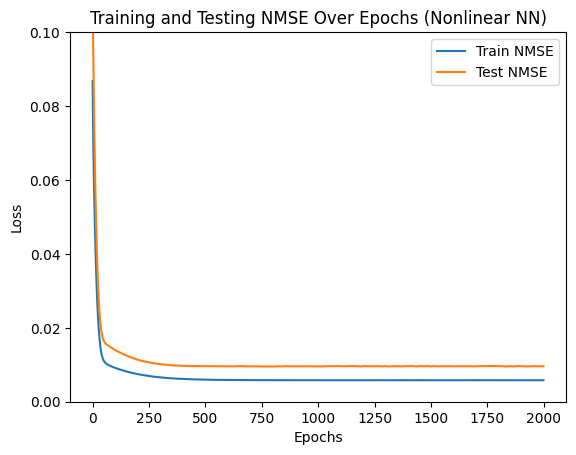

In [ ]:
# Print final training and testing NMSE
print("Train NMSE NN =", losses[-1])
print("Test NMSE NN =", losses_test[-1])

# Plot the NMSE
plt.plot(losses, label="Train NMSE")
plt.plot(losses_test, label="Test NMSE")
plt.ylim(0, 0.1)  # Set y-axis limits to [0.0, 0.1]
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Testing NMSE Over Epochs")
plt.show()


In [80]:
#load from a npy file
tr_embeddings = np.load("data/embeddings.npy")
te_embeddings = np.load("data/test_embeddings.npy")

In [82]:
tr_embeddings.shape

(550, 1390)

In [93]:
# Train the model with specified parameters
losses, losses_test, model = train(
    xs_train=torch.tensor(tr_embeddings.T, dtype=torch.float32),  # Change to float32
    ys_train=torch.tensor(np.array(train_outcomes), dtype=torch.float32).unsqueeze(-1),  # Change to float32
    xs_test=torch.tensor(te_embeddings.T, dtype=torch.float32),  # Change to float32
    ys_test=torch.tensor(np.array(test_outcomes), dtype=torch.float32).unsqueeze(-1),  # Change to float32
    regularization=0.0,    # Equivalent to `regularization = 0.000`
    nepochs=2000,          # Number of epochs
    batchsize=1000,        # Batch size
    opt_fn=optim.Adam,     # Optimizer function
    learning_rate=0.004,   # Equivalent to `Flux.Adam(0.004)`
    verbose=True,         # Disable progress bar
    nonlinear=False         # Use linear model (4-layer neural network)
)


100%|██████████| 2000/2000 [00:13<00:00, 152.62it/s]


Train NMSE NN = 0.00011146380711579695
Test NMSE NN = 0.0003085560747422278


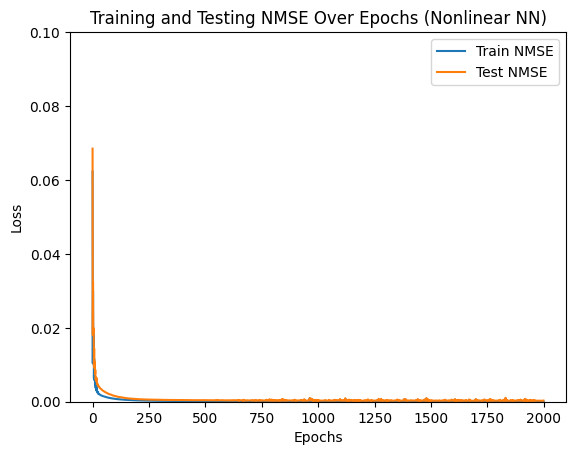

In [ ]:
# Print final training and testing NMSE
print("Train NMSE NN =", losses[-1])
print("Test NMSE NN =", losses_test[-1])

# Plot the NMSE
plt.plot(losses, label="Train NMSE")
plt.plot(losses_test, label="Test NMSE")
plt.ylim(0, 0.1)  # Set y-axis limits to [0.0, 0.1]
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Testing NMSE Over Epochs")
plt.show()
